In [1]:
import numpy as np
from pycbf import CPUCoherenceBeamformer
from pycbf import CPUBeamformer
import matplotlib.pyplot as plt
import timuscle.beamforming as tibf
import timuscle.dataio as dio
from scipy.signal import hilbert, coherence

In [2]:
path = "/home/wew12/data/invivo/RawData/"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230512_P003_v2/acq_06_flex_42_pushfocus_25mm/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230519_P006/acq_05_kf_43_vl_L/RawData"
path = "/fastrs/ultrasound/TIMuscle/InVivo/20230421_V001/acq_2_flex_45_musc_vl/RawData"

rf, dims, params = dio.verasonics_loadbmoderf(path)

t = dims['t_sec']

c = params['c']
f = params['f']
lam = c/f

na = int(params['track_params']['rf']['na'])
dtheta = params['track_params']['rf']['dtheta']

steers = dtheta * (np.arange(na) - (na-1)/2)

nele = int(params['trans']['nele'])
dele = params['trans']['dele']
xele = dele * (np.arange(nele) - (nele-1)/2)

fnum = 0.8

xout, zout = tibf.make_recon_grid_by_BW_2D(
    fnum = fnum,
    lam = lam,
    xmin = -20E-3,
    xmax = 20E-3,
    zmin = 1E-3,
    zmax = 50E-3
)

tautx, taurx, apodtx, apodrx = tibf.make_tabs_and_apods_pw_2D(
    steers=steers,
    c=c,
    xele=xele,
    xout=xout,
    zout=zout,
    fnum=1
)

In [3]:
bmfrm = CPUCoherenceBeamformer(
    tautx=tautx,
    taurx=taurx,
    apodtx=apodtx,
    apodrx=apodrx,
    t0 = t[0],
    dt = t[1]-t[0],
    nt = len(t)
)

In [4]:
im = bmfrm(rf[:,12,:,:].transpose(1, 0, 2)).reshape(-1,len(xout), len(zout))

100%|██████████| 128/128 [00:12<00:00, 10.65it/s]


In [5]:
def calc_coherence(subset):
    # subtract the mean of each aline
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    # caculate the lag-n coherence
    rhos = np.zeros(len(sig)-1)
    for lag in range(subset.shape[1]-1):
        cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
        rhos[lag] = np.mean(cross / (sig[:n-lag] * sig[lag:]))
    
    return rhos

def calc_lagn_coherence(subset, lag:int):
    submmu = subset - np.mean(subset, axis=0, keepdims=True)
    sig = np.std(subset, axis=0)
    n = len(sig)

    cross = np.mean(submmu[:,:n-lag] * submmu[:,lag:], axis=0)
    return np.mean(cross / (sig[:n-lag] * sig[lag:]))

In [6]:
apodrx_coherence = apodrx.reshape(-1, len(xout), len(zout))

In [7]:
from tqdm.notebook import tqdm

  0%|          | 0/170 [00:00<?, ?it/s]

/tmp/ipykernel_323056/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


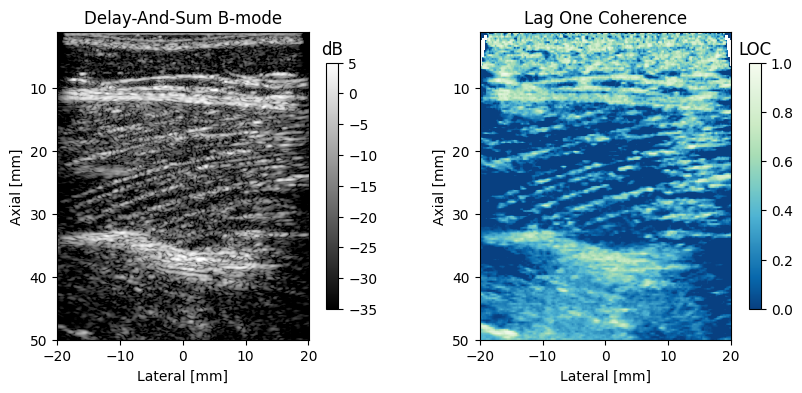

In [8]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(0.5 * lam / (dz)/2))
dsfx = 2
dsfz = 4*dsfx

loc = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
for ix in tqdm(range(0, xout.size, dsfx)):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        channels = im[elesel,ix,izmin:izmax]

        loc[ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(loc.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
plt.show()

In [9]:
def calc_coherence_2d(channels, usf:int, alpha:float=0.1):
    """calculate the 2D coherence function for the input subset of channels
    
    # Parameters
    - `channels`: a 2D array with the shape (`nax`, `nele`) which are the number of axial pixels and number of elements respectively
    - `usf`: an integer upsample factor in the axial direction
    - `alpha`: the portion of the tukey window that tapers off - a tukey window is applied axially

    # Returns
    - `rhos`: a 2D spatial coherence function with dimensions (`nax`*`usf`-3, `nele`)
    """
    from scipy.signal import resample
    from scipy.signal.windows import tukey

    # upsample axially to get better angular resolution
    win = tukey(channels.shape[0], alpha)
    subrsmp = resample(channels, channels.shape[0]*usf, axis=0, window=win)

    # subtract the mean of each aline
    submmu = subrsmp - np.mean(subrsmp, axis=0, keepdims=True)

    # get the dimensions of the data
    nax  = submmu.shape[0]
    nele = submmu.shape[1]

    # make an output buffer
    rhos = np.zeros((nax-3, nele-1))
    for alag in range(nax-3):
        # subslice the upsampled data and calculate the standard deviations
        suba0 = submmu[:nax-alag,:]
        siga0 = np.std(suba0, axis=0)
        suba1 = submmu[    alag:,:]
        siga1 = np.std(suba1, axis=0)

        for elag in range(nele-1):
            cross = np.mean(suba0[:,:nele-elag] * suba1[:,elag:], axis=0)
            rhos[alag,elag] = np.mean(cross / (siga0[:nele-elag] * siga1[elag:]))
    
    return rhos

In [10]:
def calc_radial_integral(data, x1, x2, alphas, rmin, rmax, nr:int=101, kind='linear'):
    """Calculate the radial integral of data at each alpha from rmin to rmax"""
    from scipy.interpolate import RegularGridInterpolator
    import numpy as np

    fcalc = RegularGridInterpolator((x1,x2), data, kind, bounds_error=False, fill_value=np.nan)

    r = np.linspace(rmin, rmax, nr)
    cal = np.cos(alphas)
    sal = np.sin(alphas)

    x1out = sal[:,None] * r[None,:]
    x2out = cal[:,None] * r[None,:]

    interp = fcalc(np.array([x1out,x2out]).transpose(1, 2, 0))

    return np.nanmean(interp, axis=-1)

def calc_radial_max(data, x1, x2, alphas, rmin, rmax, nr:int=101, kind='linear'):
    """Calculate the radial integral of data at each alpha from rmin to rmax"""
    from scipy.interpolate import RegularGridInterpolator
    import numpy as np

    fcalc = RegularGridInterpolator((x1,x2), data, kind, bounds_error=False, fill_value=np.nan)

    r = np.linspace(rmin, rmax, nr)
    cal = np.cos(alphas)
    sal = np.sin(alphas)

    x1out = sal[:,None] * r[None,:]
    x2out = cal[:,None] * r[None,:]

    interp = fcalc(np.array([x1out,x2out]).transpose(1, 2, 0))

    return np.nanmax(interp, axis=-1)

In [37]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(4 * lam / (dz)/2))
dsfx = 4
dsfz = 4*dsfx
usf = 2
alpha = 0.1

loc = []
for ix in tqdm(range(0, xout.size, dsfx)):
    subloc = []
    for iz in tqdm(range(0, zout.size, dsfz), leave=False):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2:
            subloc.append(None)
            continue

        channels = im[elesel,ix,izmin:izmax]

        subloc.append(calc_coherence_2d(channels.T, usf, alpha))
    loc.append(subloc)

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

/tmp/ipykernel_323056/3492521316.py:37: RuntimeWarning: invalid value encountered in divide
  rhos[alag,elag] = np.mean(cross / (siga0[:nele-elag] * siga1[elag:]))


  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

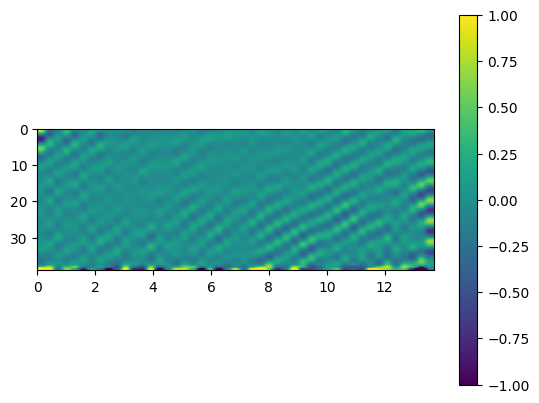

496875


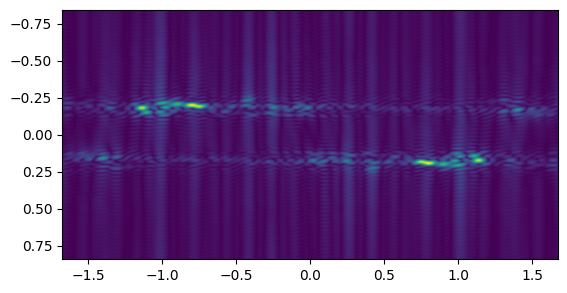

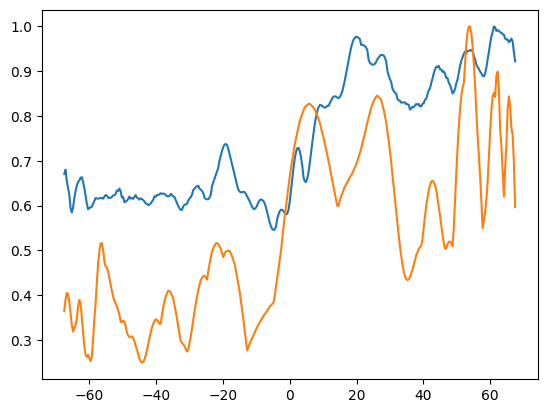

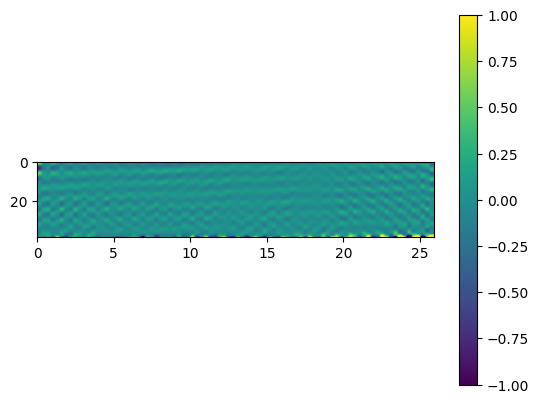

899024


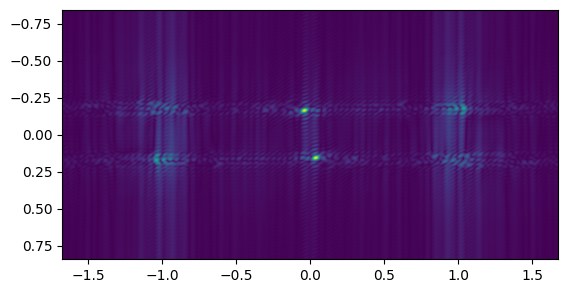

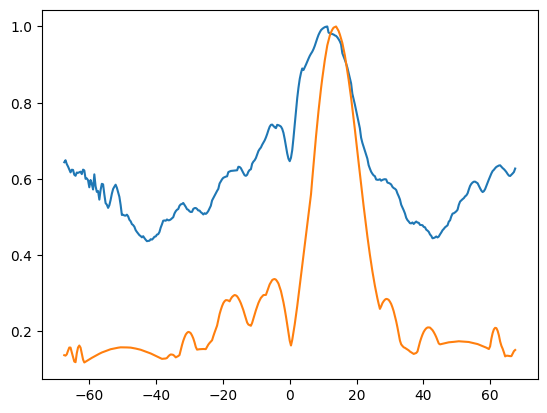

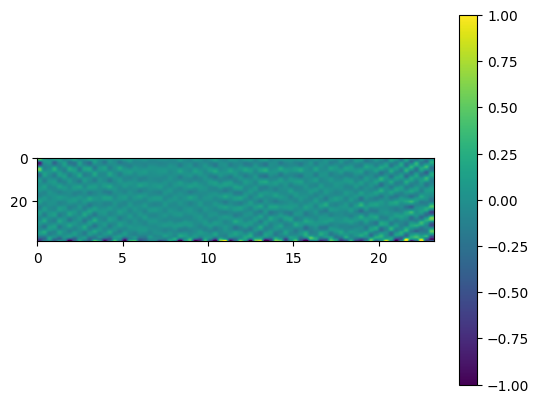

524800


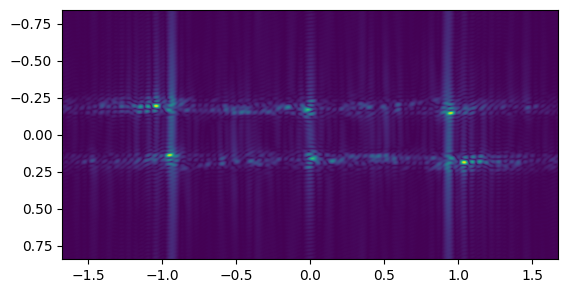

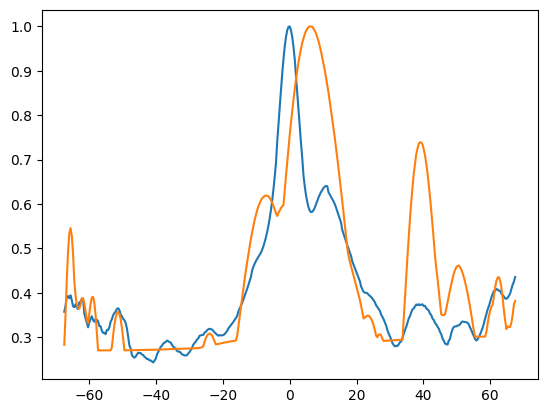

In [38]:
dax = dsfz * (zout[1]-zout[0])
dele = xele[1] - xele[0]
for ix, iz in [(4, 44), (44,44), (60,44)]:
    rho = loc[ix][iz]
    ex_rho = 1E3*np.array([0, dele*(rho.shape[1]-1), dax*(rho.shape[0]-1),0])
    plt.figure()
    plt.imshow(rho, aspect=1/(4*usf), vmin=-1, vmax=1, extent=ex_rho)
    plt.colorbar()
    plt.show()

    spec = np.abs(np.fft.fftshift(np.fft.fft2(rho, [16*ndim for ndim in rho.shape])))
    kax = np.fft.fftshift(np.fft.fftfreq(spec.shape[0], 1E3*dax))
    klat = np.fft.fftshift(np.fft.fftfreq(spec.shape[1], 1E3*dele))

    ex_kspace = [klat[0], klat[-1], kax[-1], kax[0]]
    plt.figure()
    plt.imshow(spec, extent=ex_kspace)

    print(np.argmax(spec))
    plt.show()

    alphas = np.linspace(np.pi/8, 7*np.pi/8, 361)
    rmin = 0.01
    rmax = 1.5
    
    integral = calc_radial_integral(spec, kax, klat, alphas, rmin, rmax, kind='linear')
    integral /= np.max(integral)

    maxes = calc_radial_max(spec, kax, klat, alphas, rmin, rmax, kind='linear')
    maxes /= np.max(maxes)

    imax = np.argmax(integral)
    plt.figure()
    plt.plot(90-np.degrees(alphas), integral)
    plt.plot(90-np.degrees(alphas), maxes)
    #plt.axvline(np.degrees(alphas[imax]))
    plt.show()


In [39]:
locim = np.zeros((len(loc), len(loc[0])))
thetas = np.zeros((len(loc), len(loc[0])))
for ix in tqdm(range(locim.shape[0])):
    for iz in range(locim.shape[1]):
        try:
            rho = loc[ix][iz]
            # ex_rho = 1E3*np.array([0, dele*(rho.shape[1]-1), dax*(rho.shape[0]-1),0])
            # plt.figure()
            # plt.imshow(rho, aspect=1/(4*usf), vmin=-1, vmax=1, extent=ex_rho)
            # plt.colorbar()
            # plt.show()

            spec = np.abs(np.fft.fftshift(np.fft.fft2(rho, [16*ndim for ndim in rho.shape])))
            kax = np.fft.fftshift(np.fft.fftfreq(spec.shape[0], 1E3*dax))
            klat = np.fft.fftshift(np.fft.fftfreq(spec.shape[1], 1E3*dele))

            # ex_kspace = [klat[0], klat[-1], kax[-1], kax[0]]
            # plt.figure()
            # plt.imshow(spec, extent=ex_kspace)

            # print(np.argmax(spec))
            # plt.show()

            alphas = np.linspace(np.pi/8, 7*np.pi/8, 361)
            rmin = 0.01
            rmax = 1.5
            
            # integral = calc_radial_integral(spec, kax, klat, alphas, rmin, rmax, kind='cubic')
            # integral /= np.max(integral)

            maxes = calc_radial_max(spec, kax, klat, alphas, rmin, rmax, kind='linear')
            maxes /= np.max(maxes)

            imax = np.argmax(maxes)

            thetas[ix, iz] = np.pi/2 - alphas[imax]
            locim[ix,iz] = rho[0,1]
        except:
            locim[ix,iz] = np.nan
            thetas[ix, iz] = np.nan

  0%|          | 0/85 [00:00<?, ?it/s]

/tmp/ipykernel_323056/835567805.py:35: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(interp, axis=-1)


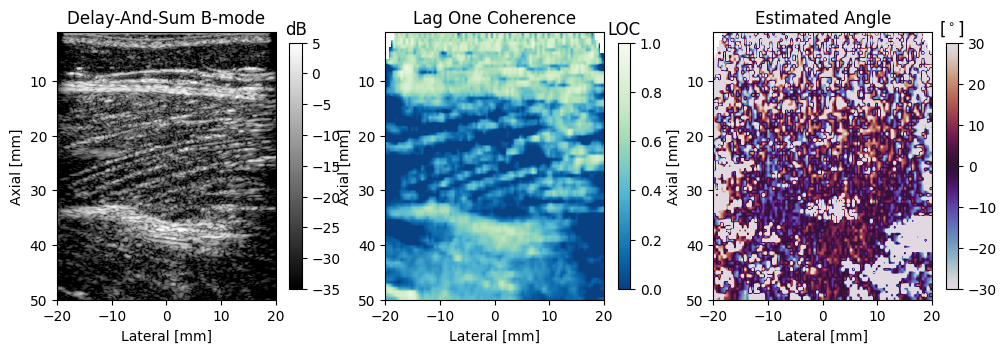

In [45]:
fig, axes = plt.subplots(1, 3)
fig.set_size_inches(12, 4)
ax = axes[1]
pltim = ax.imshow(locim.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")

ax = axes[2]
pltim = ax.imshow(np.degrees(thetas.T), alpha = np.array(locim.T > -10.00, dtype=float), cmap='twilight', extent=ex_axlat, vmin=-30, vmax=30)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Estimated Angle")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("[$^\\circ$]")
plt.show()

  0%|          | 0/85 [00:00<?, ?it/s]

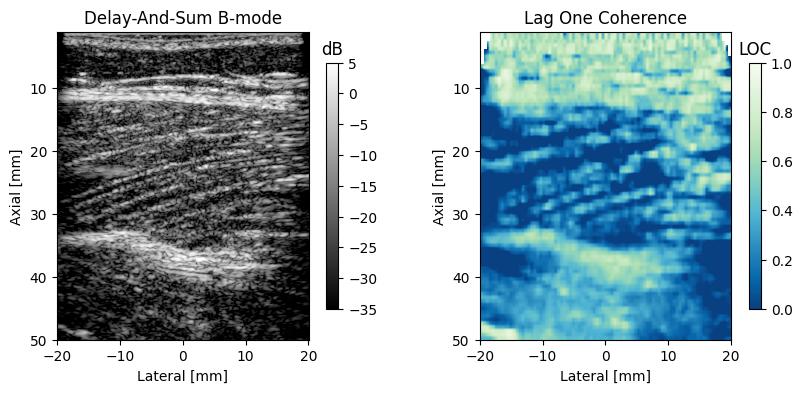

In [44]:
locim = np.zeros((len(loc), len(loc[0])))
for ix in tqdm(range(locim.shape[0])):
    for iz in range(locim.shape[1]):
        try:
            locim[ix, iz] = loc[ix][iz][0,1]
        except:
            locim[ix,iz] = np.nan

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(locim.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
plt.show()

  0%|          | 0/85 [00:00<?, ?it/s]

/tmp/ipykernel_305025/2663387294.py:21: RuntimeWarning: invalid value encountered in divide
  return np.mean(cross / (sig[:n-lag] * sig[lag:]))


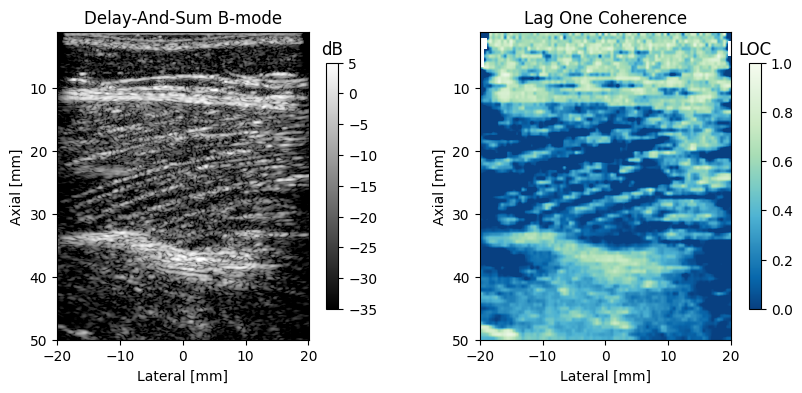

In [50]:
dz = zout[1]-zout[0]
nkern = int(np.ceil(2 * lam / (dz)/2))
dsfx = 4
dsfz = 4*dsfx

loc = np.zeros((1+xout.size//dsfx, 1+zout.size//dsfz))
for ix in tqdm(range(0, xout.size, dsfx)):
    for iz in range(0, zout.size, dsfz):
        izmin = np.max([0, iz-nkern])
        izmax = np.min([zout.size, iz+nkern+1])

        mask = apodrx_coherence[:,ix,izmin:izmax]
        elesel = np.sum(mask, axis=-1) == mask.shape[-1]

        if np.sum(elesel) < 2: continue

        channels = im[elesel,ix,izmin:izmax]

        loc[ix//dsfx,iz//dsfz] = calc_lagn_coherence(channels.T, 1)

ex_axlat = 1E3*np.array([xout[0], xout[-1], zout[-1], zout[0]])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 4)
ax = axes[1]
pltim = ax.imshow(loc.T, cmap='GnBu_r', extent=ex_axlat, vmin=-0.0, vmax=1)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Lag One Coherence")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("LOC")

env = np.abs(hilbert(np.sum(im, axis=0), axis=-1)).T
logged = 20 * np.log10(env/np.percentile(env, 99))

ax = axes[0]
pltim = ax.imshow(logged, vmin=-35, vmax=5, cmap='gray', extent=ex_axlat)
ax.set_ylabel("Axial [mm]")
ax.set_xlabel("Lateral [mm]")
ax.set_title("Delay-And-Sum B-mode")
plt.colorbar(pltim, ax=ax, shrink=0.8).ax.set_title("dB")
plt.show()

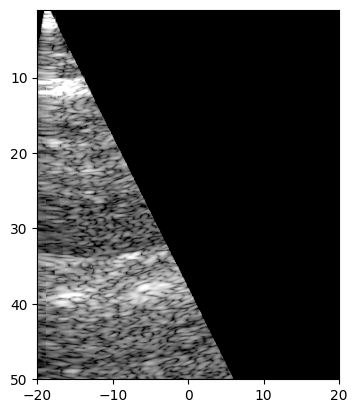

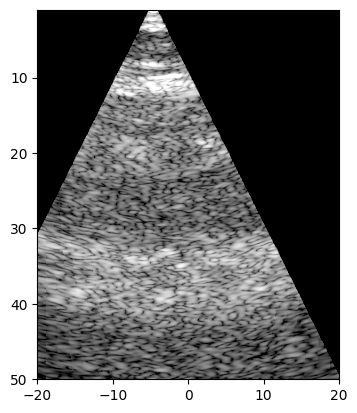

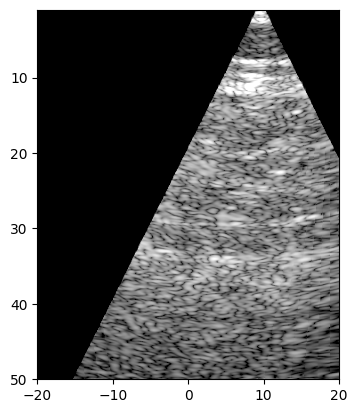

In [15]:
for iele in [0, 192//4, 192//2]:
    env = np.abs(hilbert(im[iele], axis=-1)).T
    logged = 20 * np.log10(env/np.percentile(env, 99) + 1E-80)

    plt.figure()
    plt.imshow(logged, vmin=-35, vmax=5, extent=ex_axlat, cmap='gray')
    plt.show()

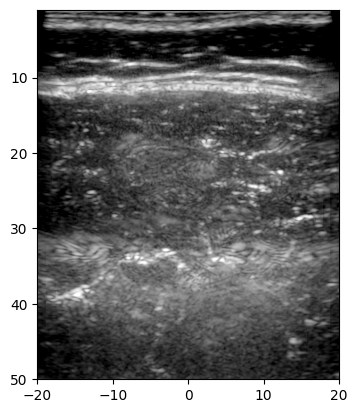

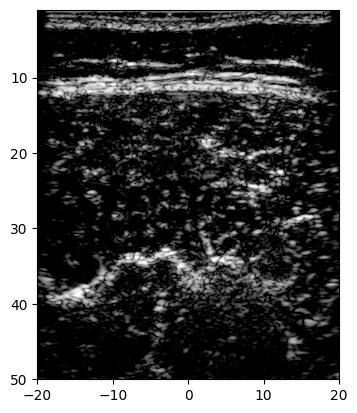

In [28]:
nsplit = 16
env = np.sum(
    [np.abs(hilbert(np.sum(im[isplit::nsplit],axis=0), axis=-1)) for isplit in range(nsplit)]
    , axis=0).T
logged = 20 * np.log10(env/np.percentile(env, 99) + 1E-80)

plt.figure()
plt.imshow(logged, vmin=-25, vmax=5, extent=ex_axlat, cmap='gray')
plt.show()

nsplit = 1
env = np.sum(
    [np.abs(hilbert(np.sum(im[isplit::nsplit],axis=0), axis=-1)) for isplit in range(nsplit)]
    , axis=0).T
logged = 20 * np.log10(env/np.percentile(env, 99) + 1E-80)

plt.figure()
plt.imshow(logged, vmin=-25, vmax=5, extent=ex_axlat, cmap='gray')
plt.show()